# Vacunacions

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

/Users/arnauquindos/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data prep

In [42]:
# Load data
url = "https://dadescovid.cat/static/csv/catalunya_diari_total_pob.zip"
resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read()))
df = pd.read_csv(zipfile.open(zipfile.namelist()[0]), sep=";")

# Column transformation and select
df["DATA"] = df.DATA.astype('datetime64[ns]')
df = df[df.DATA>datetime(2021, 1, 1)]
df = df.sort_values("DATA")

# New columns
df["cum1"] = df.VACUNATS_DOSI_1.cumsum()
df["cum2"] = df.VACUNATS_DOSI_2.cumsum()
df["firstDayWeek"] = df.DATA - df.DATA.dt.weekday * timedelta(days=1)

In [43]:
df.head()

,NOM,CODI,DATA,SEXE,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,...,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,cum1,cum2,firstDayWeek
1034,CATALUNYA,GLOBAL,2021-01-02,Home,Menors de 15,53,196,280,1,0,...,32,23,31,187,278,0,0,0,0,2020-12-28
1026,CATALUNYA,GLOBAL,2021-01-02,Altres,NaN,35,613,2,11,0,...,15,19,1,600,2,2,0,2,0,2020-12-28
1027,CATALUNYA,GLOBAL,2021-01-02,Dona,Entre 15 i 64,690,3191,2561,27,4,...,458,211,396,2879,2417,548,0,550,0,2020-12-28
1028,CATALUNYA,GLOBAL,2021-01-02,Dona,Entre 65 i 74,69,328,233,15,3,...,51,19,50,296,221,65,0,615,0,2020-12-28
1033,CATALUNYA,GLOBAL,2021-01-02,Home,Majors de 74,64,666,253,44,3,...,29,32,31,577,217,249,0,864,0,2020-12-28


## Daily

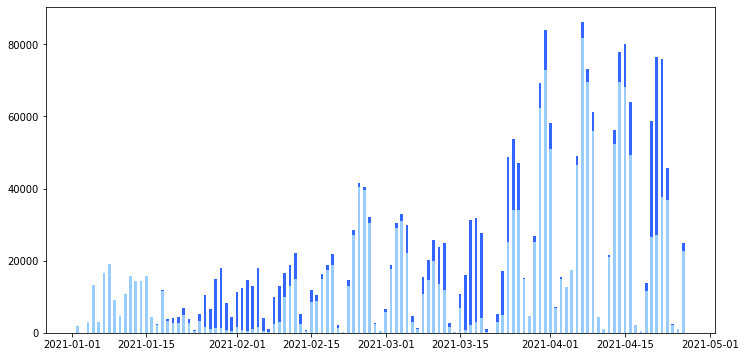

In [44]:
vac_cols = ["VACUNATS_DOSI_1", "VACUNATS_DOSI_2"]
vd = df.groupby("DATA", as_index=False)[vac_cols].sum()
fig, ax = plt.subplots(figsize=(12,6))
p1 = ax.bar(vd.DATA, vd.VACUNATS_DOSI_1, width=0.5, color = [(0.6, 0.8, 1)])
p2 = ax.bar(vd.DATA, vd.VACUNATS_DOSI_2, width=0.5, bottom=vd.VACUNATS_DOSI_1, color=[(0.2, 0.4, 1)])

## Weekly

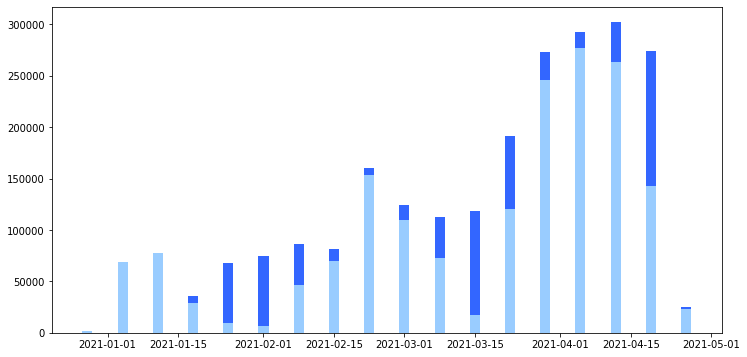

In [45]:
vac_cols = ["VACUNATS_DOSI_1", "VACUNATS_DOSI_2"]
vw = df.groupby("firstDayWeek", as_index=False)[vac_cols].sum()
fig, ax = plt.subplots(figsize=(12,6))
p1 = ax.bar(vw.firstDayWeek, vw.VACUNATS_DOSI_1, width=2, color = [(0.6, 0.8, 1)])
p2 = ax.bar(vw.firstDayWeek, vw.VACUNATS_DOSI_2, width=2, bottom=vw.VACUNATS_DOSI_1, color = [(0.2, 0.4, 1)])

## Cumulative

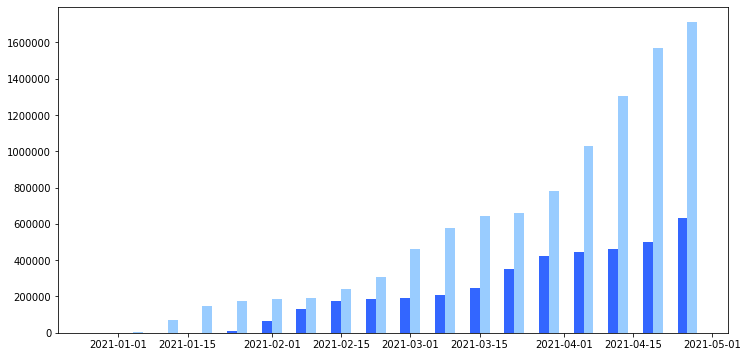

In [56]:
cum_cols = ["cum1", "cum2"]
vcw = df.groupby("firstDayWeek", as_index=False)[cum_cols].first()
fig, ax = plt.subplots(figsize=(12,6))
w = 2
p1 = ax.bar(vcw.firstDayWeek+timedelta(days=w/2), vcw.cum1, width=w, color = [(0.6, 0.8, 1)], align='center')
p2 = ax.bar(vcw.firstDayWeek-timedelta(days=w/2), vcw.cum2, width=w, color = [(0.2, 0.4, 1)], align='center')